In [29]:
import discopy # Discopy version 0.5.0 is required
import lambeq
from discopy.grammar.pregroup import Ty, Word, Cup, Diagram
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP, Rz, Controlled, Id
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend
import numpy as np
from discopy import CircuitFunctor, qubit
from collections import defaultdict
from nltk.tokenize import word_tokenize
from random import shuffle

In [52]:
s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
MASK = Word('MASK', n)

vocab = [Alice, loves, Bob]

In [81]:
params = {'Alice':0.23, 'loves': 0.6, 'Bob':0.1}

In [73]:
def generate_Functor(params):
    Func = CircuitFunctor(
        ob={s: qubit ** 1, n: qubit ** 1},
        ar={Alice: simple_noun_ansatz(params['Alice']),
            loves: simple_verb_ansatz(params['loves']),
            Bob: simple_noun_ansatz(params['Bob']),
            MASK: simple_noun_ansatz_masked()})
    return Func

In [74]:
corpus = [('Alice loves Bob', 2), ('Alice loves Bob', 0)]

In [75]:
parser = lambeq.BobcatParser()

In [76]:
def simple_noun_ansatz(phase):
    return Ket(0)>>Rz(phase)>>Rx(phase)>>Rz(phase)

def simple_verb_ansatz(phase):
    return Ket(0,0,0) >> H @ H @ H >> Controlled(Rz(phase)) @ Id(qubit) >> Id(qubit) @ Controlled(Rz(phase))

def simple_noun_ansatz_masked():
    return Ket(0)

def simple_verb_ansatz_masked():
    return Ket(0,0) >> H @ Circuit.id(1) >> CX

In [78]:
data = []

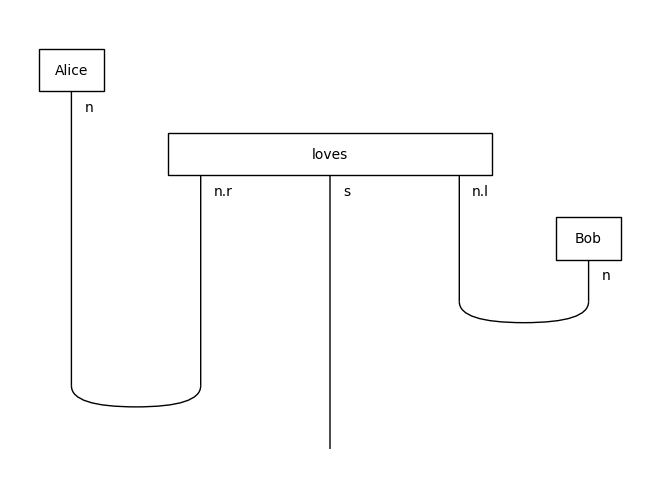

In [79]:
parser.sentence2diagram('Alice loves Bob').draw()

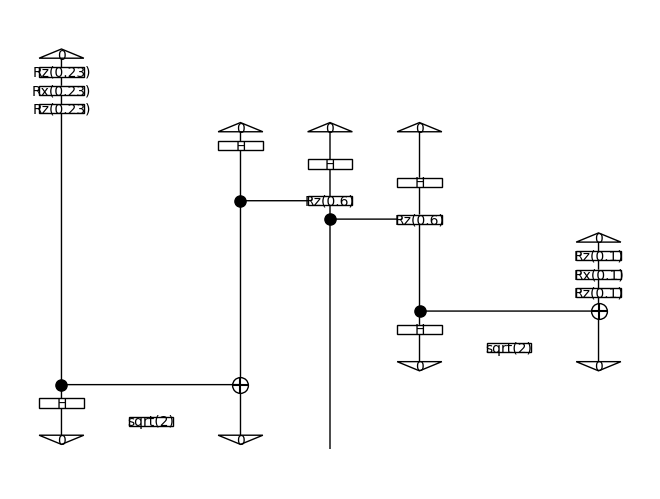

Tensor(dom=Dim(1), cod=Dim(2), array=[-0.31119285+0.01731511j, -0.21001664-0.02771888j])

In [82]:
circ = generate_Functor(params)(parser.sentence2diagram('Alice loves Bob'))
circ.draw()
circ.eval()

In [382]:
def build_data():
    """
    We build a data list in form of: [[sen, masked sen, eval of sen with random params], ...]
    :return:
    """
    for tuple in corpus:
        data_point = []

        #Append the sentence
        sen = tuple[0]
        data_point.append(sen)

        #Apply the masking
        mask_index = tuple[1]
        i=0
        string=''
        for token in word_tokenize(sen):
            if i == mask_index:
                string += ' MASK '
            else:
                string += ' ' + str(token) + ' '
            i+=1
        data_point.append(string)

        #Get the evaluation of the origin sentence for y_true
        circ = generate_Functor(params)(parser.sentence2diagram(sen))
        circ_eval = Circuit.eval(
            circ,
            backend=AerBackend(),
            n_shots=1024,
            seed=1,
            compilation=AerBackend().default_compilation_pass(2))
        data_point.append(np.abs(circ_eval.array))
        data.append(data_point)


build_data()

[['Alice loves Bob', ' Alice  loves  MASK ', 0.11718750000000006],
 ['Alice loves Bob', ' MASK  loves  Bob ', 0.11718750000000006]]

In [383]:
data

[['Alice loves Bob', ' Alice  loves  MASK ', 0.11718750000000006],
 ['Alice loves Bob', ' MASK  loves  Bob ', 0.11718750000000006]]

In [384]:
'''
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend
tk_circ = circuit.to_tk()
tk_to_qiskit(tk_circ).draw()
'''

'\nfrom pytket.extensions.qiskit import tk_to_qiskit, AerBackend\ntk_circ = circuit.to_tk()\ntk_to_qiskit(tk_circ).draw()\n'

In [385]:
epochs = 100
lr = 2

In [386]:
def loss(y_true, y_pred):
    return (y_true - y_pred)**2

In [387]:
def update(loss, updating_params):
    for param in updating_params:
        params[param] = params[param.strip()] + lr * loss

In [388]:
def train():
    for _ in range(epochs):
        for data_point in data:
            masked_sen = data_point[1]
            y_true = data_point[2]
            #Create circuit
            circ = generate_Functor(params)(parser.sentence2diagram(masked_sen))
            #Evaluate Circuit
            circ_eval = Circuit.eval(
                circ,
                backend=AerBackend(),
                n_shots=1024,
                seed=1,
                compilation=AerBackend().default_compilation_pass(2))
            # Get the evaluation as scalar
            qugit = np.abs(circ_eval.array)
            # Get the loss
            ls = loss(y_true, qugit)
            # Get the to be updated parameters
            updating_params = []
            for token in word_tokenize(masked_sen):
                if str(token) != 'MASK' and str(token) != '':
                    updating_params.append(str(token))
            # Update
            update(ls, updating_params)
            # Print
            print(params, ls)
            # Redo for next data point
        # Redo for number of epochs

In [389]:
train()

{'Alice': 0.13323364257812503, 'loves': 0.13323364257812503, 'Bob': 0.1} 0.016616821289062514
{'Alice': 0.13323364257812503, 'loves': 0.14800415039062503, 'Bob': 0.11477050781250002} 0.007385253906250005
{'Alice': 0.13433227539062503, 'loves': 0.14910278320312503, 'Bob': 0.11477050781250002} 0.00054931640625
{'Alice': 0.13433227539062503, 'loves': 0.15508422851562503, 'Bob': 0.12075195312500002} 0.002990722656250003
{'Alice': 0.13460693359375003, 'loves': 0.15535888671875003, 'Bob': 0.12075195312500002} 0.0001373291015625
{'Alice': 0.13460693359375003, 'loves': 0.15685424804687503, 'Bob': 0.12224731445312502} 0.0007476806640625
{'Alice': 0.13488159179687503, 'loves': 0.15712890625000003, 'Bob': 0.12224731445312502} 0.0001373291015625
{'Alice': 0.13488159179687503, 'loves': 0.15822753906250003, 'Bob': 0.12334594726562502} 0.00054931640625
{'Alice': 0.13500366210937503, 'loves': 0.15834960937500003, 'Bob': 0.12334594726562502} 6.103515625e-05
{'Alice': 0.13500366210937503, 'loves': 0.159

In [390]:
params

{'Alice': 0.13573608398437503,
 'loves': 0.16787109375000003,
 'Bob': 0.13213500976562503}

In [392]:
# Short test cell
circ = generate_Functor(params)(parser.sentence2diagram('Alice loves MASK'))
circ_eval = Circuit.eval(
    circ,
    backend=AerBackend(),
    n_shots=1024,
    seed=1,
    compilation=AerBackend().default_compilation_pass(2))
qugit = np.abs(circ_eval.array)
qugit - 0.11718750000000006 # Compare to our reference value

0.0

In [ ]:
def train():
    for _ in range(epochs):
        for data_point in corpus:
            global m
            m=data_point[1]

            global counter
            counter = -1

            sen = data_point[0]

            masked_sentence = " ".join(["MASK" if i == m else word for i, word in enumerate(sen.split())])
            print(masked_sentence)
            masked_list=[masked_sentence.replace("MASK", name) for name in params.keys()]
            print(masked_list)

            y_pred = []
            for tryout in masked_list:
                circ = generate_functor()(parser.sentence2diagram(tryout))
                circ_eval = Circuit.eval(
                    circ,
                    backend=AerBackend(),
                    n_shots=1024,
                    seed=1,
                    compilation=AerBackend().default_compilation_pass(2))
                rep = np.abs(circ_eval.array)
                y_pred.append(1-abs(rep-test_dict[sen])) #decimal bibl
            logits = softmax(y_pred)
            ls = loss(y_true, qugit)
            #updating_params = []
            #for token in word_tokenize(sen):
            #    if word_tokenize(sen).index(token) != m:
             #       updating_params.append(str(token))
            #update(ls, updating_params)
            #print(ls)
